In [1]:
import catboost as cb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
model = cb.CatBoostRegressor(cat_features=['region'])
model = model.load_model('multi_output_model')

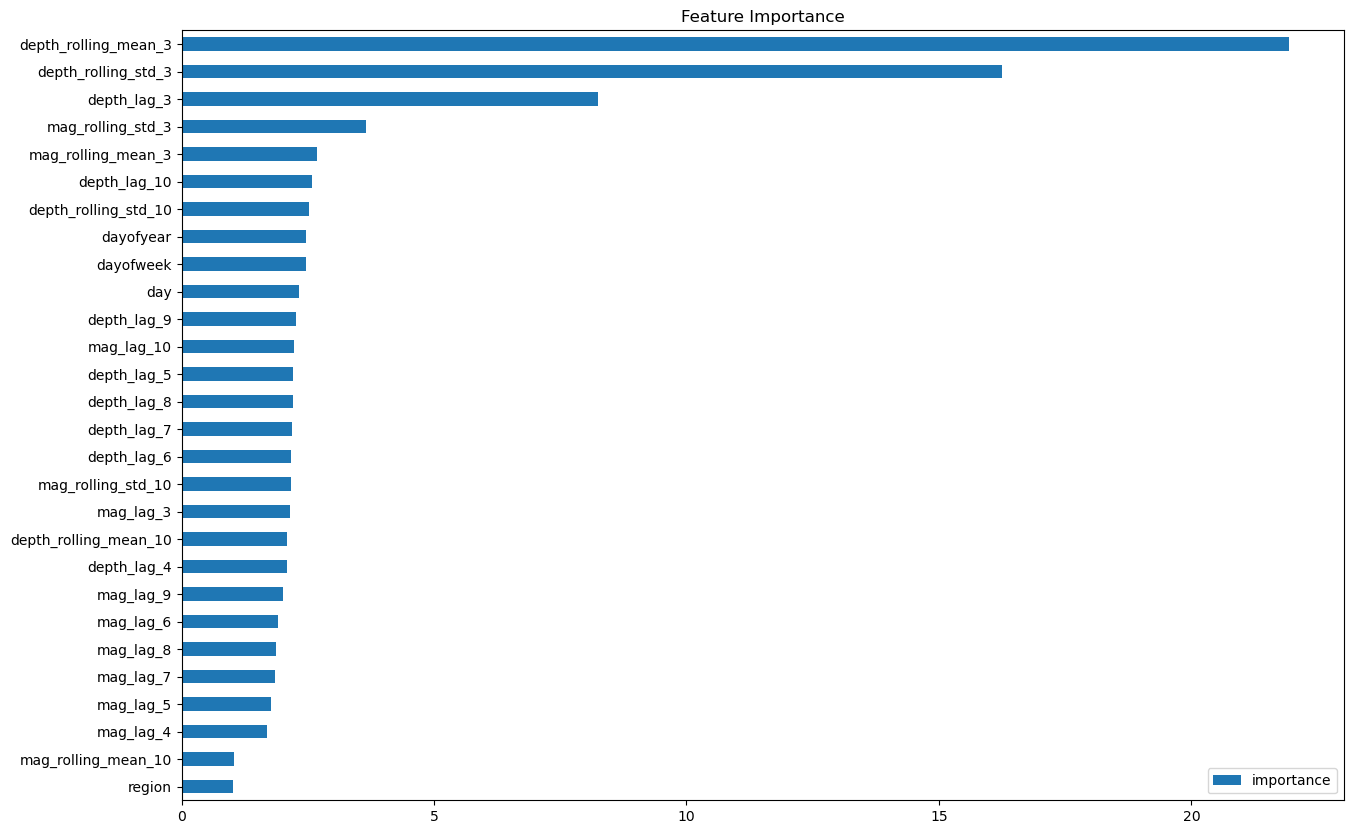

In [3]:
fi = pd.DataFrame(data=model.get_feature_importance(), index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()